Совместный хакатон студентов курсов Data Science и Менеджер проектов, где они работают в командах над разработкой ML-модели для сопоставления текстов музыкальных произведений и для поиска каверов (вариации обработки оригинала с элементами новой аранжировки) по их текстам.

Необходимо разработать ML-продукт, который:

- Находит все кавер-треки и/или исходники к заданному треку в датасете
- Перечисляет все кавер-треки и/или оригиналы к заданному, указывает положение данного трека в цепочке каверов

### Разметка каверов

Файл covers.json содержит разметку каверов, сделанную редакторами сервиса:

- track_id - уникальный идентификатор трека;
- track_remake_type - метка, присвоенная редакторами. Может принимать значения ORIGINAL и COVER;
- original_track_id - уникальный идентификатор исходного трека.

💡 Обратите внимание, что не для всех каверов известны идентификаторы исходных треков!!!
### Метаинформация

- track_id - уникальный идентификатор трека;
- dttm - первая дата появления информации о треке;
- title - название трека;
- language - язык исполнения;
- isrc - международный уникальный идентификатор трека;
- genres - жанры;
- duration - длительность трека;

### Текст песен

- track_id - уникальный идентификатор трека;
- lyricId - уникальный идентификатор текста;
- text - текст трека.

In [1]:
!pip install -U sentence-transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 26.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 55.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 24.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 52.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 75.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 29.8 MB/s eta 0:00:00
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125923 sha256=f634ad012b6bc7758d10eb75423a49f7c3e7cc19135e51c1db610a02993b7f57
  Stored in directory: /root/.cache/pip/wheels/62/f2/10/1e606fd5f02395388f74e7462910fe851042f97238cbbd902f
Successfully built sentence-transformers


In [2]:
!pip install ipywidgets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 11.8 MB/s eta 0:00:00


In [47]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sentence_transformers import SentenceTransformer


In [5]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


### meta

In [6]:
meta = pd.read_json('/gdrive/MyDrive/Colab Notebooks/meta.json', lines=True)

In [7]:
meta['track_id'].duplicated().sum()

0

In [8]:
meta = meta.set_index('track_id')
meta['dttm'] = pd.to_datetime(meta['dttm'], unit='ms')

In [9]:
meta.head()

,dttm,title,language,isrc,genres,duration
track_id,,,,,,
c3b9d6a354ca008aa4518329aaa21380,2021-12-16 21:00:00,Happy New Year,EN,RUB422103970,[DANCE],161120.0
c57e3d13bbbf5322584a7e92e6f1f7ff,2021-11-24 14:00:33,Bad Habits,EN,QZN882178276,[ELECTRONICS],362260.0
955f2aafe8717908c140bf122ba4172d,2021-11-24 15:37:03,Por Esa Loca Vanidad,None,QZNJZ2122549,"[FOLK, LATINFOLK]",260000.0
fae5a077c9956045955dde02143bd8ff,2021-11-24 15:37:03,Mil Lagrimas,None,QZNJZ2166033,"[FOLK, LATINFOLK]",190000.0
6bede082154d34fc18d9a6744bc95bf5,2021-11-24 15:37:03,Sexo Humo y Alcohol,None,QZNJZ2122551,"[FOLK, LATINFOLK]",203000.0


In [10]:
meta.info()

<class 'pandas.core.frame.DataFrame'>
Index: 71769 entries, c3b9d6a354ca008aa4518329aaa21380 to 5731fc0a34c663a0c0082c712df15266
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   dttm      71768 non-null  datetime64[ns]
 1   title     71768 non-null  object        
 2   language  21969 non-null  object        
 3   isrc      71455 non-null  object        
 4   genres    71768 non-null  object        
 5   duration  71768 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(4)
memory usage: 3.8+ MB


In [11]:
meta['isrc'].duplicated().sum()

485

Text(0, 0.5, 'Frequency')

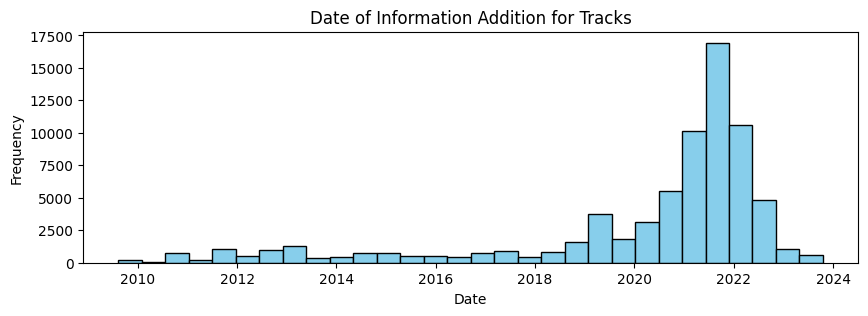

In [12]:
plt.figure(figsize=(10, 3))

plt.hist(meta['dttm'], bins=30, color='skyblue', edgecolor='black')

plt.title('Date of Information Addition for Tracks')
plt.xlabel('Date')
plt.ylabel('Frequency')

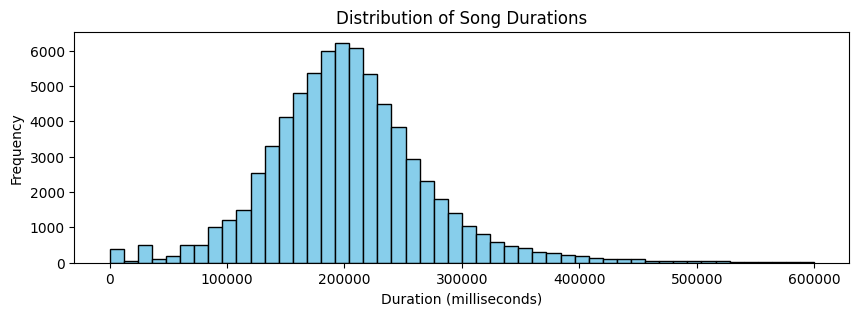

In [13]:
plt.figure(figsize=(10, 3))
plt.hist(meta['duration'], bins=50, range=(0, 600000), color='skyblue', edgecolor='black')
plt.title('Distribution of Song Durations')
plt.xlabel('Duration (milliseconds)')
plt.ylabel('Frequency')
plt.show()

## covers

In [14]:
covers = pd.read_json('/gdrive/MyDrive/Colab Notebooks/covers.json', lines=True)

In [15]:
covers['track_id'].duplicated().sum()

0

In [16]:
covers = covers.set_index('track_id')

In [17]:
covers.head()

,original_track_id,track_remake_type
track_id,,
eeb69a3cb92300456b6a5f4162093851,eeb69a3cb92300456b6a5f4162093851,ORIGINAL
fe7ee8fc1959cc7214fa21c4840dff0a,fe7ee8fc1959cc7214fa21c4840dff0a,ORIGINAL
cd89fef7ffdd490db800357f47722b20,cd89fef7ffdd490db800357f47722b20,ORIGINAL
995665640dc319973d3173a74a03860c,995665640dc319973d3173a74a03860c,ORIGINAL
d6288499d0083cc34e60a077b7c4b3e1,None,COVER


In [18]:
covers.info();

<class 'pandas.core.frame.DataFrame'>
Index: 71597 entries, eeb69a3cb92300456b6a5f4162093851 to 7b0f6ff24137be50cf5ea5f82d789448
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   original_track_id  4821 non-null   object
 1   track_remake_type  71597 non-null  object
dtypes: object(2)
memory usage: 1.6+ MB


In [19]:
covers['track_remake_type'].value_counts()

COVER       67304
ORIGINAL     4293
Name: track_remake_type, dtype: int64

список самых часто повторяющихся значений в столбце covers['original_track_id']

In [20]:
covers['original_track_id'].value_counts().head(10)

f3e5e9db509f9b6f6d93b9c38e4e1324    38
17a163f6ab3de102b49599f5577866fc    32
deb9b9598176a0bab1212d430b10bd04    31
53a04991308c2cc9179fdd401fea83a3    30
eeb69a3cb92300456b6a5f4162093851    25
9050384cce6c221c39d6e25d02561612    25
8e0235cf2a39eacc4c78885ca7dd4de3    24
ad1b9fe17c16ab73b2a52920fdb1a220    19
cfcd208495d565ef66e7dff9f98764da    17
0fcb82fec458a0993f848200548eaaa0    17
Name: original_track_id, dtype: int64

In [21]:
covers[covers['track_remake_type'] == 'ORIGINAL'].duplicated().sum()

0

Кол-во каверов с имеющимися 'original_track_id':

In [22]:
covers.loc[(covers['track_remake_type'] == 'COVER') & (~covers['original_track_id'].isna()), 'original_track_id'].count()

528

### lyrics

In [23]:
lyrics = pd.read_json('/gdrive/MyDrive/Colab Notebooks/lyrics.json', lines=True)

In [24]:
lyrics.head()

,lyricId,text,track_id
0,a951f9504e89759e9d23039b7b17ec14,"Живу сейчас обломами, обломками не той любви\n...",1c4b1230f937e4c548ff732523214dcd
1,0c749bc3f01eb8e6cf986fa14ccfc585,Tell me your fable\nA fable\nTell me your fabl...,0faea89b0d7d6235b5b74def72511bd8
2,e2c8830fbc86e5964478243099eec23a,You're ashamed about all your fears and doubts...,9c6dc41d5ccd9968d07f055da5d8f741
3,e2c8830fbc86e5964478243099eec23a,You're ashamed about all your fears and doubts...,bfd04a73e9cffdf0e282c92219a86ea1
4,7624653ca8522ba93470843c74961b7d,"You showed him all the best of you,\nBut I'm a...",8d70930d09cd239c948408d1317d8659


Дубликаты по столбцам:

In [25]:
lyrics['track_id'].duplicated().sum()

1137

In [26]:
lyrics['text'].duplicated().sum()

770

In [27]:
lyrics['lyricId'].duplicated().sum()

499

In [28]:
lyrics[lyrics['track_id'].duplicated()].sort_values('track_id')

,lyricId,text,track_id
10681,039236cf5355b4a81a7d5e689dbbf00a,Hearts go astray\nLeaving hurt when they go\nI...,0021519c8533f1116591948bbb349aef
10686,0abe3bb343894590423064dee2d2a114,Hearts go astray\nLeaving hurt when they go\nI...,0021519c8533f1116591948bbb349aef
11306,1682f991cfa94d1440bef2aa417edec7,"If I stay with you, if I'm choosing wrong\nI d...",0102189356af15ad0be804eddd9bc24a
9220,6e3781576e60cfbee15f65d626ac130a,"If I stay with you, if I'm choosing wrong\nI d...",0102189356af15ad0be804eddd9bc24a
8330,52d3570b1f1e50113f10cdd65869614e,Well sometimes I go out by myself\nAnd I look ...,02db8e8e8d3c08f3a57cc6db3876f942
...,...,...,...
8880,b48c26ba7186a8de9de9f3121a783da4,I got lost in the wilderness\nI thought I was ...,fd93fa564461b42fea969d6cc1d16c18
7556,6ba951bfe34b90ab611f63c67caa708f,This night is cold in the kingdom\nI can feel ...,ff032309afbd44985497077e1f041e97
11229,b2bd7e1c3e5b8987b0a7df143a2c3c0f,"I cover the waterfront,\nI'm watching the sea,...",ff54e3bcd7ef7aeb41c91f9abeac9c68
8881,d9107cc98fb6dc91853ea69ac98f1d58,Don't go tonight\nStay here one more time\nRem...,ff77df3ccccd54654ea4b2209dd6e38c


In [29]:
lyrics = lyrics.set_index('track_id')

In [30]:
lyrics.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11414 entries, 1c4b1230f937e4c548ff732523214dcd to c860754a50dac664d847bca85e6897f4
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   lyricId  11414 non-null  object
 1   text     11414 non-null  object
dtypes: object(2)
memory usage: 267.5+ KB


Дубликаты по обоим столбцам:

In [31]:
lyrics.duplicated().sum()

499

Дубликаты по совпадению первых 50 знаков по столбце 'text':

In [32]:
lyrics['text'].str[:50].duplicated().sum()

2076

In [33]:
lyrics['text'].str[:50].value_counts()

Kiss me hard before you go\nSummertime sadness\nI ju    24
The world was on fire and no one could save me but      23
Sweet dreams are made of this\nWho am I to disagree     20
Twenty-five years and my life is still\nI'm trying      16
Load up on guns, bring your friends\nIt's fun to lo     15
                                                        ..
Un gatto bianco con gli occhi blu\nUn vecchio vaso       1
За мои зелёные глаза\nНазываешь ты меня колдуньей\nГ     1
I'm a Barbie girl, in the Barbie world\nLife in pla      1
As coisas que tinham valor\nEu perdi e o mal triunf      1
Этой ночью чьё-то сердце от любви горит\nВсё внутри      1
Name: text, Length: 9338, dtype: int64

## Объединенный датасет

In [34]:
df = meta.join(covers, how='left')
df = df.join(lyrics, how='left')

In [35]:
df.tail()

,dttm,title,language,isrc,genres,duration,original_track_id,track_remake_type,lyricId,text
track_id,,,,,,,,,,
fffc8f02feca70f7fad88fb987b76c4e,2021-10-02 00:35:55,La Luz de la Cara Roja,None,ARAB82100052,"[ROCK, ALLROCK]",200100.0,None,COVER,NaN,NaN
fffefc046267a3f6263fc2c8d0f3f871,2021-10-11 21:47:01,Uska Hi Banana,None,QZNJX2142230,[FOLK],185880.0,None,COVER,NaN,NaN
ffff8f1c01d78267ce067a2507fcc8f8,2019-05-17 16:50:33,No Limit,None,PLS921752714,[],175950.0,None,COVER,NaN,NaN
ffff9a22aa441db772206280ffb8b52e,2015-02-04 21:00:00,You're a Woman,None,None,[POP],321820.0,ffff9a22aa441db772206280ffb8b52e,ORIGINAL,748ffc10cc43b1a7e5524ad11fb9a182,Tonight\nBe no darkness tonight\nHold tight\nL...
None,NaT,None,None,None,None,NaN,NaN,NaN,NaN,NaN


In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 72906 entries, 0000757a652c12554a82002cd90cc10a to None
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   dttm               72905 non-null  datetime64[ns]
 1   title              72905 non-null  object        
 2   language           22870 non-null  object        
 3   isrc               72566 non-null  object        
 4   genres             72905 non-null  object        
 5   duration           72905 non-null  float64       
 6   original_track_id  5378 non-null   object        
 7   track_remake_type  72571 non-null  object        
 8   lyricId            11414 non-null  object        
 9   text               11414 non-null  object        
dtypes: datetime64[ns](1), float64(1), object(8)
memory usage: 6.1+ MB


In [37]:
df.describe(include='all')

<ipython-input-37-174ba9bf1a5c>:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df.describe(include='all')


,dttm,title,language,isrc,genres,duration,original_track_id,track_remake_type,lyricId,text
count,72905,72905,22870,72566,72905,7.290500e+04,5378,72571,11414,11414
unique,27726,45462,85,71283,232,NaN,4468,2,10915,10644
top,2013-03-11 20:00:00,Morena,EN,US4BR0500030,"[FOLK, LATINFOLK]",NaN,f3e5e9db509f9b6f6d93b9c38e4e1324,COVER,28fbafaf626c497d0d4d933b4f0d3f5b,Twenty-five years and my life is still\nI'm tr...
freq,864,81,16121,24,18399,NaN,41,67770,9,15
first,2009-08-10 17:32:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,2023-10-18 21:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,2.051841e+05,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,8.537061e+04,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,0.000000e+00,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,1.616300e+05,NaN,NaN,NaN,NaN


## LaBSE

В этом хакатоне вам предлагается разработать решение, которое:

1. может классифицировать треки по признаку кавер-некавер.  



- связывать (группировать) каверы и исходный трек;
- находит исходный трек в цепочке каверов.



Как работает модель SentenceTransformer('LaBSE'):

Подается текст в модель.  
Модель автоматически токенизирует текст, добавляет специальные токены [CLS] и [SEP], и преобразует текст в числовые токены.  
Модель кодирует текст с учетом его контекста и внутренних представлений BERT.
Векторное представление предложения извлекается из внутренних скрытых состояний модели.  
Если  на вход подаются тексты разной длины, то модель автоматически обработает их и создаст векторные представления, даже если длины текстов различаются.

In [38]:
model = SentenceTransformer('sentence-transformers/LaBSE')

[[ 0.02882475 -0.00602381 -0.05947007 ... -0.03002252 -0.029607
   0.00067483]
 [-0.05550233  0.02546483 -0.02157258 ...  0.02932105  0.01150041
  -0.00848787]]


In [43]:
df_without_nan = df[df['text'].notna()]
df_without_nan['text'].head(100)

track_id
0000757a652c12554a82002cd90cc10a    दिल क्यूँ ये मेरा शोर करे?\nदिल क्यूँ ये मेरा ...
00017038a565df4b72048268e7623599    Se que nada pasara\nSi mañana no me ves\nY ten...
000801d33025623d7de5b42f40b37ddf    Секунду назад было нежно и тихо\nЛетали, шепта...
0014e3765c38c9f86fa57e5c40ff8910    Just a small town girl\nLivin' in a lonely wor...
0016ea67c5fd2d71eee4b8c583d3a6b7    On a dark desert highway\nCool wind in my hair...
                                                          ...                        
023341f3c1236d93bc35920c99f40eb3    Won't you come see about me?\nI'll be alone, d...
023b84e49ef23432a92173ebd4970c65    Let's go to the beach, each\nLet's go get a wa...
02463cf8dd7ccd8283ac029c9692fd21    First when there's nothing but a slow glowing ...
02595d6adc91939d4aa9151cf3df299c    Breaking my back just to know your name\nSeven...
025b0cb1df23e592310dbd6726fb8bee    Quem é você\nQue toda noite liga pra mim\nQue ...
Name: text, Length: 100, dtype: object

In [44]:
embeddings = model.encode(df_without_nan['text'].head(100))
print(embeddings)

[[-0.06922301 -0.02750809 -0.0557544  ... -0.02462904 -0.05165264
  -0.01176211]
 [-0.04058443 -0.03139252 -0.01885115 ... -0.03261949 -0.05487094
  -0.06033562]
 [-0.05911702 -0.0316225  -0.05803477 ... -0.03008229 -0.04123494
  -0.01780361]
 ...
 [-0.05070161 -0.05787892 -0.0421053  ... -0.03040243  0.00108064
  -0.05934952]
 [-0.05399565 -0.05947971 -0.05476186 ...  0.03625406 -0.06823204
  -0.07095026]
 [-0.03386588 -0.05695167 -0.03128488 ... -0.03580378 -0.05531958
  -0.00888631]]


In [ ]:
# from transformers import AutoModel, AutoTokenizer
# import torch

# model_name = "setu4993/LaBSE"
# model = AutoModel.from_pretrained(model_name)
# tokenizer = AutoTokenizer.from_pretrained(model_name)

# texts = ["Привет, как дела?", "LaBSE - отличная модель!", "Многие языки поддерживаются LaBSE."]

# encoded_input = tokenizer(texts, padding=True, truncation=True, return_tensors="pt")
# with torch.no_grad():
#     model_output = model(**encoded_input)

# # Извлечение векторов из модели
# embeddings = model_output.last_hidden_state.mean(dim=1)  # Среднее значение векторов токенов

# for i, text in enumerate(texts):
#     print(f"Текст: {text}")
#     print(f"Вектор: {embeddings[i]}")


In [49]:
#model = SentenceTransformer('LaBSE')

In [60]:
reference_texts = ["Vous pouvez utiliser LaBSE pour différentes langues."]
reference_embedding = model.encode(reference_texts)
#reference_embeddings

In [58]:
texts = [
    "You can use LaBSE for various languages.",
    "Получение векторных представлений для текстов",
    "Вывод векторов для каждого предложения",
    "Можно использовать LaBSE для различных языков."
]

# Получение векторных представлений для текстов
sentence_embeddings = model.encode(texts)

# Вывод векторов для каждого предложения
# for sentence, embedding in zip(texts, sentence_embeddings):
#     print(f"Sentence: {sentence}")
#     print(f"Embedding: {np.array(embedding)}")
#     print()

In [51]:
from sentence_transformers import util

In [62]:
similarities = util.pytorch_cos_sim(reference_embedding, sentence_embeddings)[0]

# Ранжируем тексты по схожести (чем ближе к 1, тем более похожи)
sorted_indices = similarities.argsort()[::1]

# Вывод ранжированных текстов
print("Ранжированные тексты:")
for i, idx in enumerate(sorted_indices):
    print(f"{i + 1}: {texts[idx]} (Схожесть: {similarities[idx]:.4f})")

Ранжированные тексты:
1: Вывод векторов для каждого предложения (Схожесть: 0.2363)
2: Получение векторных представлений для текстов (Схожесть: 0.2716)
3: You can use LaBSE for various languages. (Схожесть: 0.9611)
4: Можно использовать LaBSE для различных языков. (Схожесть: 0.9755)


In [65]:
reference_embedding.dtype

dtype('float32')

In [63]:
# # Ранжируем тексты по схожести (чем ближе к 1, тем более похожи)
# sorted_indices = similarities.argsort()[::1]

# # Создаем список ранжированных текстов
# ranked_texts = [texts[idx] for idx in sorted_indices]
# ranked_similarities = [similarities[idx] for idx in sorted_indices]

# # Вывод ранжированных текстов
# print("Ранжированные тексты:")
# for i, (text, similarity) in enumerate(zip(ranked_texts, ranked_similarities)):
#     print(f"{i + 1}: {text} (Схожесть: {similarity:.4f})")

Ранжированные тексты:
1: Вывод векторов для каждого предложения (Схожесть: 0.2363)
2: Получение векторных представлений для текстов (Схожесть: 0.2716)
3: You can use LaBSE for various languages. (Схожесть: 0.9611)
4: Можно использовать LaBSE для различных языков. (Схожесть: 0.9755)
